In [228]:
%matplotlib inline
import pandas
import numpy as np
import pylab as plt
from IPython.display import clear_output
from scipy import optimize

In [216]:
# lets load the dataframe we made in the previous ipython notebook (tma_analysis_sacla.ipynb)
df = pandas.read_pickle("run656748_main.pkl")

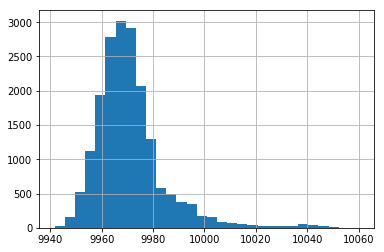

In [217]:
# We wish to compute difference-radial profiles at different time delays

#The first step is filtering all the profiles 
# (removing bad shots or shots with outlier parameters)

#We can easily filter shots according to a photon energy bandpass
#First, however,  we should see the spectrum!
df.photon_energy.hist(bins=30)

In [218]:
energy_rng = (9955, 9980)
df_bandpass = df.query("%.5f < photon_energy < %.5f"%energy_rng)

In [219]:
#Now lets filter according to signal to background level

#We will make a function to do this

def filter_radials( df, 
    bg_rng,  
    sig_rng, 
    thresh=1.3):
  
    """
    this filters radials that have a weak signal

    df, pandas dataframe
    bg_rng, tulple defininig where the background signal is
    sig_rng, tuple defining where the signal is (e.g. water ring)
    thresh, only keep radials if signal is greater than background by
        this fraction

    returns a filtered pandas dataframe
    """
    
    assert( bg_rng[1] > bg_rng[0])
    assert( sig_rng[1] > sig_rng[0])

    # background and signal slices
    bg_slc = slice( bg_rng[0], bg_rng[1],1)
    sig_slc = slice( sig_rng[0], sig_rng[1], 1)
    
    # load the radial stack
    rads = np.vstack(df.radials.values)
    # define the signal  to background levels for each radial profile
    sig = rads[ :, sig_slc].mean(axis=1)
    bg = rads[ :, bg_slc].mean(axis=1)
    lvl = sig/bg

    is_good = lvl > thresh
    
    df_good = df.loc[is_good]
    
    print("func `filter_radials`: \
        \n\tKeeping %d / %d rads"%(sum( is_good), len( df)))
    
    df_bad = df.loc[~is_good]

    return df_good, df_bad



(150, 1000)

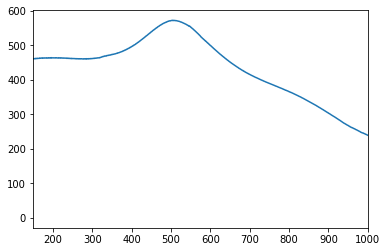

In [220]:
# lets plot the average radial to visually check good ranges for background and signal
plt.plot( df_bandpass.radials.mean(0))
plt.xlim(150,1000) # zoom into the relvant bits

In [221]:
# based on the above plot, we choose regions of interest:

bg_rng = (180,220) # radial pixel values of background
sig_rng = (510,550) # radial pixel values of signal
df_kept, df_removed = analyze_radials.filter_radials(df_bandpass, 
                                                     bg_rng=bg_rng, 
                                                     sig_rng=sig_rng, 
                                                     thresh=1.2)

func `filter_radials`:         
	Keeping 6030 / 13851 rads


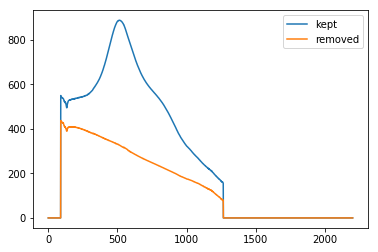

In [222]:
# lets plot the filtered and removed profiles to compare
plt.plot( df_kept.radials.mean(0), label='kept')
plt.plot( df_removed.radials.mean(0), label='removed')
plt.legend()

In [229]:
# now it is a good idea to start doing the pumped and dark difference profiles
# To do this , first gather the darks
df_dark = df_kept.query("pumped==False")

# We are interested in computing difference profiles at various time delays
# We can find pumped profiles at a given time delay using a basic query:
df_pumped_2ps = df_kept.query("1.75 < delay_time < 2.25 ").query("pumped==True")

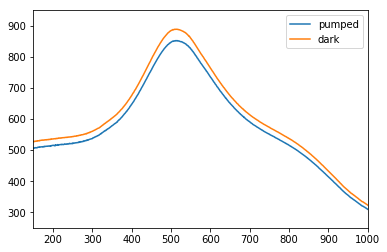

In [230]:
# lets plot the 2ps pumped and dark profiles
plt.plot( df_pumped_2ps.radials.mean(0), label="pumped")
plt.plot( df_dark.radials.mean(0), label="dark")
plt.xlim(150,1000) # zoom into the relvant bits
plt.ylim(250,950)
plt.legend()

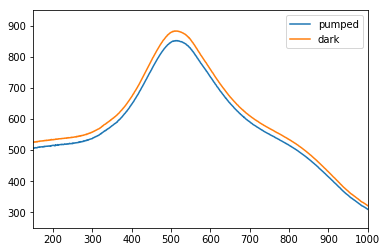

In [225]:
# note how they appear to differ in scale
# This could be due to intensity fluctutions or jet fluctuations, its hard to say for sure

# We can just look at the dark shots that were measured
# around the same time as the pumped shots:
tagmin, tagmax = df_pumped_2ps.tagNumber.min(), df_pumped_2ps.tagNumber.max()
df_dark_concurrent = df_dark.query( "%d < tagNumber < %d"%(tagmin, tagmax))

# and plot
plt.plot( df_pumped_2ps.radials.mean(0), label="pumped")
plt.plot( df_dark_concurrent.radials.mean(0), label="dark")
plt.xlim(150,1000) # zoom into the relvant bits
plt.ylim(250,950)
plt.legend()

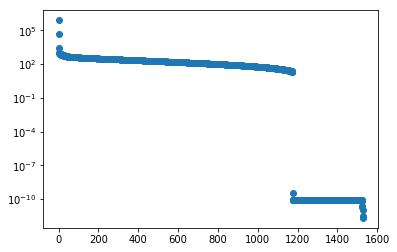

In [226]:
# Note, they are still off slightly.. 
# It could be the pumped profiles have more signal in general 
# , however it could be other factors which are unaccounted for

# We can get more fancy with the subtraction... 

#####################################
# Lets run SVD on all the dark vectors
# and then use linear fits of those most prominant 
# singular vectors to each individual pumped profile 
####################################

# Here we do the singular decomp:
    
dark_stack = np.vstack(df_dark.radials.values)
U,s,VT = np.linalg.svd( dark_stack.T, full_matrices=False)

# two most prominant dark singular vectors 
v0 = U[:,0]*s[0]
v1 = U[:,1]*s[1]
vecs = [v0,v1]

# we can plot the singular values to check prominance
plt.plot( s, 'o')
plt.gca().set_yscale("log")

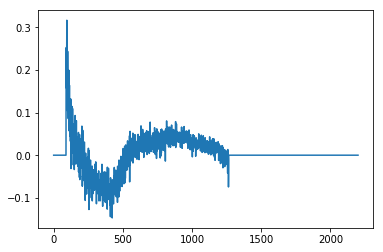

In [231]:
# looks like 2-sh dominant components, hence why we only kept two

# We wish to fit a linear combination of the vectors to each pumped profile

# We can fit the linear combination, but we need a good initial condition

# Lets let the initial condition be the average right singular vectors
c0 = VT[0].mean()
c1 = VT[1].mean()

# here is a plot of the residual of the SVD reconstruction to the original dark vector
# using our guessed coefficients
plt.plot(df_dark.radials.mean(0) - v0*c0 -v1*c1 )

#note this is residual on top of roughly 1000 y-axis units


In [232]:
# seems like a good fit
# Now lets see what happens if we fit this to a pumped profile


# first we define e residual least squares function
def opt_func(coeffs, vecs, pumped):
    """
    coeffs, tuple of parameters
    vecs, the dark sigular vectors [ U[:,0]*s[0], U[:,1]*s[1], ... ]
    pumped, a pumped radial profile, could be average or singular shot
    
    returns the sum of squared residuals
    """
    linear_comb_of_vecs = _get_linear_comb( coeffs, vecs)
    resid = pumped - linear_comb_of_vecs
    return np.sum(resid**2)

def _get_linear_comb(coeffs, vecs):
    """
    Returns a linear combination of vectors based on params. 
    
    Params must be N+1 long where N is the number
    of dark vectors. The extra parameters (at the end of the list)
    is the constant offset
    
    coeffs, same linear coeffs passed to opt_func
    vecs, same dark_vecs passed to opt_func
    """
    linear_comb = np.zeros_like(vecs[0])
    for v,c in zip( vecs, coeffs[:-1] ):
        linear_comb += v*c
    linear_comb += coeffs[-1]
    return linear_comb



In [238]:

# Now this is a random single shot radial profile
pumped_radial = df_pumped_2ps.radials.iloc[0]

# lets fit some dark singular vectors to it
init_params = (c0,c1,coffset)
fit = optimize.minimize( opt_func, init_params , args=( [v0,v1], pumped_radial  ), method='Nelder-Mead')
dark_fit = _get_linear_comb( fit['x'], [v0,v1])

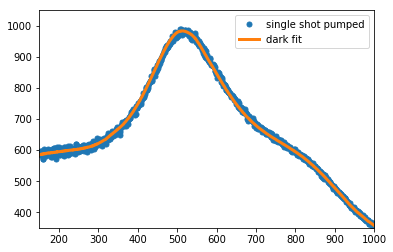

In [239]:
# lets check out fit
plt.plot( pumped_radial, 'o', ms=5 ,label='single shot pumped')
plt.plot( dark_fit, lw=3, label='dark fit')
plt.xlim(150,1000)
plt.ylim(350,1050)
plt.legend()

In [240]:
# Now we can apply this to each pumped profile
# Since we will use this multiple times, lets make a function

def fit_darks_to_pumps(df_pumped, 
                       x0=(c0,c1,coffset), 
                       vecs = [v0,v1], 
                       method='Nelder-Mead', 
                       fun=opt_func):

    results = {}
    results['dark_fits'] = []
    results['differences'] = []
    results['success'] = []
    results['residuals'] = []

    for i_pumped, pumped in enumerate(df_pumped.radials):

        if i_pumped %50==0:
            clear_output(wait=True)
            print ("Pumped %d/ %d"%(i_pumped+1, len(df_pumped)))
        fit = optimize.minimize( opt_func, 
                                x0 = x0, 
                                args=( vecs, pumped  ), method=method)
        dark_fit = _get_linear_comb( fit['x'], [v0,v1])

        results['dark_fits'].append( dark_fit)
        results['residuals'].append( fit['fun'])
        results['differences'].append( pumped - dark_fit)
        results['success'].append( fit['success'])
    
    clear_output()
    print("Done!\n")
    return results



In [236]:
results = fit_darks_to_pumps(df_pumped_2ps)

Done!



(50, 1050)

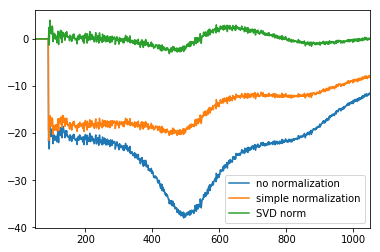

In [237]:
# lets compare some various normalizations

# no norm
plt.plot( df_pumped_2ps.radials.mean(0) - df_dark.radials.mean(0), label='no normalization')

# scale by water peak
pumped_stack = np.vstack( df_pumped_2ps.radials.values)
dark_stack = np.vstack(df_dark.radials.values)

# normalize the pumped by the water peak
pumped_water_peak = pumped_stack[:, 510:550].max(1) 
pumped_stack /= pumped_water_peak[:,None]
# same for darks
dark_water_peak = dark_stack[:, 510:550].mean(1)
dark_stack /= dark_water_peak[:,None]
plt.plot( (pumped_stack.mean(0) - dark_stack.mean(0) )*pumped_water_peak.mean() , label="simple normalization")


plt.plot( np.mean( results['differences'],0), label="SVD norm")
plt.legend()
plt.xlim(50,1050)

In [214]:
# looks like the SVD fit works nicely